In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [122]:
import sys
sys.path.append('../src/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from zoo import ResNet3dCSN2P1D

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

import SimpleITK as sitk
from src.datasets.cls_dataset import ClassifierDataset
# from src.datasets.seg_dataset import read_folder_sitk

from src.aug.seg_aug import SameResAugsAlbu
from src.metrics.cls_metric import Metric
from src.losses.seg_loss import SegFastLossCalculator
from src.metrics.seg_metrics import multiclass_dice_coefficient
import glob

In [123]:
from dataclasses import dataclass

In [124]:
ROOT = 'data'

In [125]:
df = pd.read_csv(f"{ROOT}/train_spleen.csv")
# pids = np.array(os.listdir(f"{ROOT}/liver_dataset/liver_crops"), dtype=int)
# print(df.shape)
# df = df[df.patient_id.apply(lambda x: True if x in pids else False)]
# print(df.shape)
# df = df.reset_index()
# df.to_csv(f"{ROOT}/train_liver.csv")

In [271]:
@dataclass
class CFG:
    # dataset
    path_to_images: str = f"{ROOT}/spleen_dataset/spleen_crops"
    path_to_meta_csv: str = f"{ROOT}/train_spleen.csv"
    fold: int = 4
    shape: tuple = (128, 128, 64) # whd
    target: str = 'multi'
    num_workes: int = 6
    group: str = "Egor"
    description: str = '''baseline adamw+plateuo only 1 scan weighted loss'''
    
    # training
    num_classes: int = 3
    batch_size: int = 8
    wandb_project: str = 'RSNA_classification_spleen'
    default_root_dir: str = 'cls'
    checkpoints_dir: str = 'cls/checkpoints'
    lr: float = 3e-4
    weight_decay: float = 1e-2
    max_epochs: int = 300

# Note: you need to define `ROOT` somewhere above the dataclass for the f-strings to work.

In [272]:
CFG = CFG()

In [273]:
# import torch
# from torch.utils.data import DataLoader, WeightedRandomSampler

# def make_binary_balanced_sampler(labels):
#     """Create a sampler for balanced sampling."""
#     class_counts = {}
#     for label in labels:
#         class_counts[label] = class_counts.get(label, 0) + 1

#     num_samples = len(labels)
#     weights = [1.0 / class_counts[label] for label in labels]

#     sampler = WeightedRandomSampler(weights, num_samples)
#     return sampler

In [274]:
train_dataset = ClassifierDataset(
    mode = "train",
    target=CFG.target,
    fold = CFG.fold,
    path_to_images = CFG.path_to_images,
    path_to_meta_csv = CFG.path_to_meta_csv,
    shape = CFG.shape
)

In [275]:
val_dataset = ClassifierDataset(
    mode = "eval",
    target=CFG.target,
    fold = CFG.fold,
    path_to_images = CFG.path_to_images,
    path_to_meta_csv = CFG.path_to_meta_csv,
    shape = CFG.shape
)

In [276]:
test_dataset = ClassifierDataset(
    mode = "test",
    target=CFG.target,
    fold = CFG.fold,
    path_to_images = CFG.path_to_images,
    path_to_meta_csv = CFG.path_to_meta_csv,
    shape = CFG.shape
)

In [277]:
# organ = 'spleen'
# available = np.array(os.listdir(f'/mnt/nvme13TB/RAW_DATASETS/rsna-2023/{organ}_crops/'), int)
# meta[meta.patient_id.isin(available)].to_csv(f'/mnt/nvme13TB/RAW_DATASETS/rsna-2023/train_{organ}.csv', index=False)

In [278]:
batch_size = CFG.batch_size
train_sampler = None

In [279]:
targets = train_dataset.meta[["healthy", "low", "high"]].values.argmax(1)

In [280]:
class_counts = np.bincount(targets)

In [281]:
class_weights = 1. / class_counts
weights = class_weights[targets]
sampler = WeightedRandomSampler(weights, len(weights))

In [282]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False, num_workers=CFG.num_workes)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workes)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workes)

In [283]:
%%time
for batch_idx, batch in enumerate(val_loader):
    print(f"Batch {batch_idx}:")
    print(f"Keys {batch.keys()}")
    print(f"Images shape {batch['image'].shape}")
    print(batch['label'])
    break

Batch 0:
Keys dict_keys(['image', 'label', 'patient_id'])
Images shape torch.Size([1, 3, 128, 128, 64])
tensor([[0, 0, 1]])
CPU times: user 7.49 ms, sys: 321 ms, total: 328 ms
Wall time: 617 ms


In [284]:
from torch import nn

from zoo import ResNet3dCSN
from zoo.utils import _initialize_weights


class ClassifierResNet3dCSN2P1D(nn.Module):
    def __init__(
        self,
        encoder="r50ir",
        pool="avg",
        norm_eval=False,
        num_classes=1,
        head_dropout=0.2,
    ) -> None:
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Dropout(head_dropout),
            nn.Linear(1024, num_classes),
        )
        self.avg_pool = (
            nn.AdaptiveAvgPool3d((1, 1, 1))
            if pool == "avg"
            else nn.AdaptiveMaxPool3d((1, 1, 1))
        )
        self.dropout = nn.Dropout(0.5)
        _initialize_weights(self)

        self.backbone = ResNet3dCSN(
            pretrained2d=False,
            pretrained=None,
            depth=int(encoder[1:-2]),
            with_pool2=False,
            bottleneck_mode=encoder[-2:],
            norm_eval=norm_eval,
            zero_init_residual=False,
        )

    def forward(self, x):
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1, 1)[:, :, :, :, :]
        x = self.backbone(x)[-1]
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.head(x)
        return x


In [285]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

class LitClassifier3d(pl.LightningModule):

    def __init__(self, config, num_classes, encoder="r50ir", pool='avg', pretrain='', **kwargs):
        super().__init__()
        self.args = config
        self.learning_rate = config.lr
        self.save_hyperparameters()            
        self.model = ClassifierResNet3dCSN2P1D(encoder=encoder, num_classes=num_classes, pool=pool)
        if pretrain:
            self.model.load_state_dict(torch.load(pretrain), strict=False)
            print(f'resumed from {pretrain}')
        
        if num_classes == 1:
            self.loss_fn = nn.BCEWithLogitsLoss() 
        else:
            self.loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 2.0, 4.0]), label_smoothing=0.1)
#             self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, batch):
        return self.model(batch['image'])
    
    def compute_f1(self, logits, labels):
        if self.hparams.num_classes == 1:
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).squeeze().long()  # Convert to binary
            labels = labels.long()
        else:
            preds = torch.argmax(logits, dim=1).long()
            labels = torch.argmax(labels, dim=1).long()

        return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
    

    def training_step(self, batch, batch_idx):
        logits = self.model(batch['image']).float()
        labels = batch['label'].float()
        if self.hparams.num_classes == 1:
            logits = logits.squeeze()
        loss = self.loss_fn(logits, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.model(batch['image']).float()
        labels = batch['label'].float()
        if self.hparams.num_classes == 1:
            logits = logits.squeeze()
        loss = self.loss_fn(logits, labels)
    
        f1 = self.compute_f1(logits, labels)

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_macro_f1", f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-2)
        lr_scheduler = {
                        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                                                factor=0.5,
                                                                                patience=8,
                                                                                threshold=0.07,),
                        'interval': 'epoch',
                        'frequency': 1,
                        'monitor': "train_loss",
                        'name': 'lr/reduce_on_plateau'
                        }
        return [optimizer], [lr_scheduler]

In [286]:
# pretrain = 'weights/vmz_ipcsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20210617-c3be9793.pth'
# pretrain = 'weights/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth'

In [287]:
# encoder_name = "r152ir"
# # encoder_name = "r152ip"
# pool = 'max'
# num_classes = 3

In [288]:
CFG.shape

(128, 128, 64)

In [289]:
# wandb_name = f'kidneys_{encoder_name}_fold2_patience8_shape_192_112_64'

In [290]:
# wandb.login()
# #8f08ab2acb47b91781c978546c53a881e5c5a3df
# wandb_logger = WandbLogger(project = CFG.wandb_project, name=wandb_name, group=CFG.group)

# wandb.config.update({k: v for k, v in CFG.__dict__.items() if not k.startswith("__")})

In [291]:
# model = LitClassifier3d(config = CFG, num_classes=num_classes, encoder = encoder_name, pool=pool, pretrain=pretrain)
# lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [292]:
# checkpoint_callback = ModelCheckpoint(
#     dirpath = CFG.checkpoints_dir,
#     monitor = 'val_loss',
#     save_top_k = 3,
#     filename = 'kidneys/' + wandb_name+ '_fold_2_{epoch}-{val_loss:.3f}',
#     mode = 'min',
#     save_weights_only=True,
# )


In [293]:
trainer = pl.Trainer(#logger = wandb_logger,
                     #default_root_dir = CFG.default_root_dir,
                     accelerator = 'cuda',
                     #amp_backend="apex",
                     #callbacks = [checkpoint_callback, lr_monitor],
                     #max_epochs = CFG.max_epochs,
                     #check_val_every_n_epoch = 1,
                     )

# trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [294]:
# model2 = LitClassifier3d.load_from_checkpoint('cls/checkpoints/spleen/spleen_r152ir_fold2_patience15_shape_128_128_64_fold_2_epoch=79-val_loss=1.152.ckpt', map_location = 'cpu', config=CFG)
# model2 = LitClassifier3d.load_from_checkpoint('cls/checkpoints/spleen/r152ir_shape:(128, 128, 96)_fold_0_epoch=33-val_loss=0.445.ckpt', config=CFG)

In [295]:
'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=61-val_loss=0.952.ckpt'
'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=84-val_loss=0.956.ckpt'
'kidneys_r152ir_fold2_patience8_shape_192_112_64_fold_2_epoch=85-val_loss=0.957.ckpt'
    
'kidneys_r152ir_fold1_patience8_shape_192_112_64_fold_2_epoch=80-val_loss=0.960.ckpt'
'kidneys_r152ir_fold1_patience10_rerun_shape_192_112_64_fold_1_epoch=54-val_loss=0.974.ckpt' 
'kidneys_r152ir_fold1_patience8_shape_192_112_64_fold_2_epoch=76-val_loss=0.964.ckpt'  


'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=130-val_loss=0.911.ckpt'
'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=178-val_loss=0.911.ckpt'
'kidneys_r152ir_fold4_patienceinf_192_112_64_fold_4_epoch=203-val_loss=0.914.ckpt'


'spleen_r152ir_fold0_patience10_shape_128_128_64_fold_0_not_1_epoch=87-val_loss=1.146.ckpt'
'spleen_r152ir_fold0_patience10_shape_128_128_64_fold_0_not_1_epoch=91-val_loss=1.154.ckpt'
'spleen_r152ir_fold0_patience10_shape_128_128_64_fold_0_not_1_epoch=75-val_loss=1.137.ckpt'

'spleen_r152ir_fold1_patience15_shape_128_128_64_fold_1_epoch=167-val_loss=1.179.ckpt'
'spleen_r152ir_fold1_patience15_shape_128_128_64_fold_1_epoch=174-val_loss=1.176.ckpt'
'spleen_r152ir_fold1_patience15_shape_128_128_64_fold_1_epoch=175-val_loss=1.177.ckpt'

'spleen_r152ir_fold2_patience15_shape_128_128_64_fold_2_epoch=143-val_loss=1.179.ckpt'
'spleen_r152ir_fold2_patience15_shape_128_128_64_fold_2_epoch=79-val_loss=1.152.ckpt'
'spleen_r152ir_fold2_patience15_shape_128_128_64_fold_2_epoch=93-val_loss=1.172.ckpt'

'spleen_r152ir_fold2_patience15_shape_128_128_64_fold_2_epoch=93-val_loss=1.172.ckpt'

In [296]:
# torch.save(model2.model.state_dict(), 'weights/spleen/spleen_fold2.pt')

In [297]:
m = ClassifierResNet3dCSN2P1D(encoder="r152ir", num_classes=3, pool='max').to('cuda')
m = m.eval()

In [298]:
m.load_state_dict(torch.load('weights/spleen/spleen_fold4.pt'))

<All keys matched successfully>

In [299]:
preds = []
for i, batch in enumerate(val_loader):
    # print(i)
    p = m(batch['image'].to('cuda')).softmax(1).detach().cpu().numpy()
    # print(p)
    preds.extend(p)

In [300]:
gts = []
for batch in val_loader:
    # p = m(batch['image'].to('cuda')).detach().cpu().numpy()
    # gts.extend(p)
    gts.extend(batch['label'].detach().cpu().numpy())

In [301]:
gts_ = np.array(gts).copy()
preds_ = np.array(preds).copy()

In [302]:
gts_.shape == preds_.shape

True

In [303]:
# 1: "liver",
# 2: "spleen",
# 3: "kidney",
# 4: "bowel",
# 5: "extravasation",

In [304]:
metric = Metric(label=2)

In [305]:
metric.get_score(gts_, preds_[:])

0.6589861570902424

In [306]:
import optuna
from functools import partial

def objective(trial, y_true, y_pred):
    y_pred = y_pred.copy()
    f0 = trial.suggest_float('f0', 0., 5., step=0.01)
    f1 = trial.suggest_float('f1', 0., 5., step=0.01)
    f2 = trial.suggest_float('f2', 0., 5., step=0.01)
    
    y_pred[:, 0] *= f0
    y_pred[:, 1] *= f1
    y_pred[:, 2] *= f2
    
    score = Metric(label=3).get_score(y_true, y_pred)
    return score

study = optuna.create_study(direction='minimize')

objective_partial = partial(objective, y_true=gts_, y_pred=preds_)
study.optimize(objective_partial, n_trials=1000)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2023-10-15 18:38:18,315] A new study created in memory with name: no-name-ba57042d-6d40-40cd-baf9-8be6e92a02cd
[I 2023-10-15 18:38:18,321] Trial 0 finished with value: 0.7119782054647048 and parameters: {'f0': 3.27, 'f1': 0.77, 'f2': 2.13}. Best is trial 0 with value: 0.7119782054647048.
[I 2023-10-15 18:38:18,324] Trial 1 finished with value: 0.7474586374079514 and parameters: {'f0': 1.1, 'f1': 4.8, 'f2': 0.61}. Best is trial 0 with value: 0.7119782054647048.
[I 2023-10-15 18:38:18,327] Trial 2 finished with value: 0.7619283923096237 and parameters: {'f0': 1.6300000000000001, 'f1': 2.35, 'f2': 4.5}. Best is trial 0 with value: 0.7119782054647048.
[I 2023-10-15 18:38:18,331] Trial 3 finished with value: 0.7228218557719338 and parameters: {'f0': 3.2, 'f1': 0.73, 'f2': 2.68}. Best is trial 0 with value: 0.7119782054647048.
[I 2023-10-15 18:38:18,334] Trial 4 finished with value: 1.448583494574049 and parameters: {'f0': 0.17, 'f1': 3.47, 'f2': 2.5100000000000002}. Best is trial 0 with 

Best parameters: {'f0': 4.51, 'f1': 4.86, 'f2': 2.72}


In [309]:
(np.array([4.9, 2.87, 1.93]) + np.array([3.38, 4.66, 2.75]) + np.array([4.51, 1.9, 2.2]) + np.array([4.63, 2.95, 2.08]) + np.array([4.51, 4.86, 2.72])) / 5

array([4.386, 3.448, 2.336])

In [308]:
# metric.get_score(gts, preds[:])

In [214]:
f1_score(gts_.argmax(1), preds_.argmax(1), average="micro")

0.8433931484502447

In [215]:
f1_score(gts_.argmax(1), preds_.argmax(1), average="macro")

0.530956883417785

In [216]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [217]:
gts_.shape

(613, 3)

In [218]:
print(roc_auc_score(gts_[:, 0], preds_[:, 0]))
print(roc_auc_score(gts_[:, 1], preds_[:, 1]))
print(roc_auc_score(gts_[:, 2], preds_[:, 2]))

0.7816091954022988
0.7232957595276436
0.9127842484747642


In [219]:
def plot_roc_curve(y_true, y_score):
    plt.figure(figsize=(10, 8))
    classes = y_true.shape[-1]
    for i in range(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = roc_auc_score(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

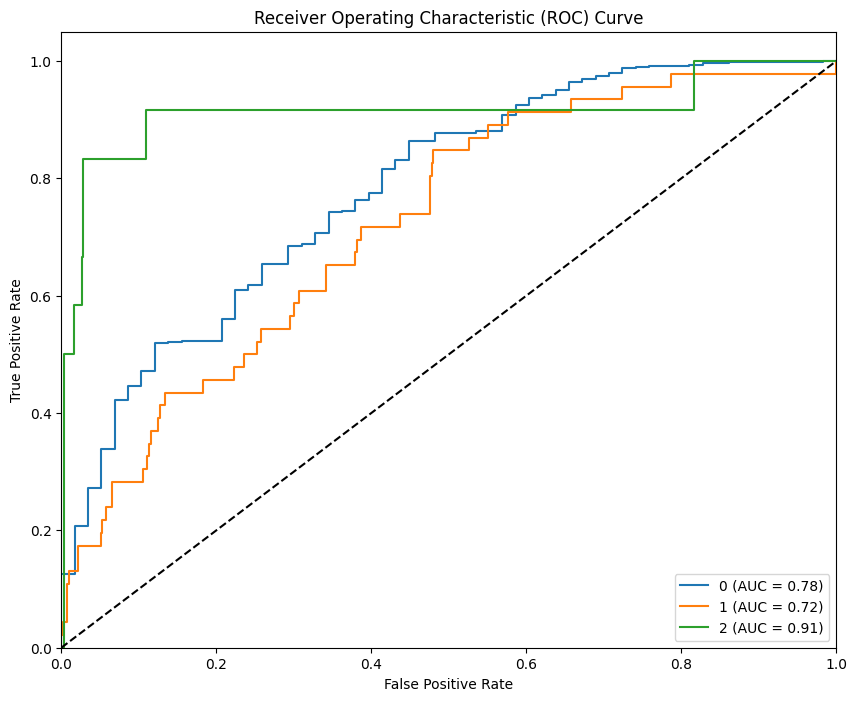

In [220]:
plot_roc_curve(gts_, preds_)

In [221]:
print(classification_report(gts_.argmax(1), preds_.argmax(1)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       555
           1       0.20      0.28      0.23        46
           2       0.40      0.50      0.44        12

    accuracy                           0.84       613
   macro avg       0.51      0.56      0.53       613
weighted avg       0.87      0.84      0.86       613

